# Visualization and statistical analysis

Define the result folder

In [1]:
import yaml
from pathlib import Path
from ipyfilechooser import FileChooser
srcdir, dstdir = '', ''
with open("config.yml", "r") as file:    
    config = yaml.safe_load(file)
    if 'source' in config.keys():
        srcdir = Path(config["source"])        
    if 'destination' in config.keys():
        dstdir = Path(config["destination"]) 

fc = FileChooser(dstdir, select_desc='Destination')
display(fc)

FileChooser(path='/home/jeromeb/work/code/octopus/results', filename='', title='', show_hidden=False, select_d…

In [4]:
import pandas as pd
dstdir = Path(fc.selected) if fc.selected is not None else Path(dstdir)
filelistname = dstdir / 'filelist.csv'
filelist = pd.read_csv(filelistname)
filelist

,Unnamed: 0,folder,name
0,0,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnal...
1,1,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnal...
2,2,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",2023_20Dec_2aBatch2_12Dec_F1_Stitched_Cropped_...
3,3,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAna...


In [5]:
import numpy as np
import tifffile
import napari

def get_files(dstdir, row, key=None):
    if key == 'ims':
        return Path(row['folder']) / row['name']
    elif key == 'regions':
        return Path(dstdir / str(row["name"]).replace('.ims','-regions.json'))
    elif key == 'labels':
        return Path(dstdir / str(row['name']).replace('.ims','-labels.tif'))
    elif key == 'measurements':
        return Path(dstdir / str(row['name']).replace('.ims','-measurements.csv'))
    elif key == 'stats':
        return Path(dstdir / str(row['name']).replace('.ims','-stats.csv'))
    else:
        return {
            'ims': get_files(dstdir, row, 'ims'),
            'regions': get_files(dstdir, row, 'regions'),
            'labels': get_files(dstdir, row, 'labels'),
            'measurements':  get_files(dstdir, row, 'measurements')
        }

def create_heatmaps(labels, df, thresholds):    
    heatmaps = np.zeros([3,*labels.shape])
    for row in df.iloc:
        for k, c in enumerate(['ch1','ch2','ch3']):
            if row[c] > thresholds[c]:
                heatmaps[k][labels == row['label']] = row[c]  
    return heatmaps

def create_codemap(labels, df):
    """Create a map of the binary codes"""
    K = len(df['code'].unique())
    code2ind = {c:k for k,c in enumerate(df['code'].unique())}
    a = np.zeros([K, *labels.shape], dtype=np.uint8)
    for row in df.iloc:
        k = code2ind[row['code']]        
        a[k][labels == row['label']] = 1
    return a, code2ind


In [6]:
import ipywidgets as widgets
w = widgets.Dropdown(
    options=[(x,k) for k,x in enumerate(filelist['name'])],
    value=1,
    description='Image:',
)
display(w)

Dropdown(description='Image:', index=1, options=(('2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnalysis.ims', 0)…

In [8]:
row = filelist.iloc[w.value]
filename = get_files(dstdir, row, 'ims')
regionname = get_files(dstdir, row, 'regions')
print("Input IMS filename:", filename)
print("Destination:", dstdir)
print("Output region file:", regionname)
cnf = yaml.safe_load(f'source: \"{srcdir}\"\ndestination: \"{dstdir}\"\n')
# update yaml config file
with open('config.yml', 'w') as file:
    yaml.dump(cnf, file)

Input IMS filename: /run/user/1000/gvfs/smb-share:server=cephfs2,share=users/acourtney/HCR_Octopus_Jerome/Febuary2024/14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAnalysis.ims
Destination: /home/jeromeb/work/code/octopus/results
Output region file: /home/jeromeb/work/code/octopus/results/14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAnalysis-regions.json


In [9]:
row = filelist.iloc[3]
labels = tifffile.imread(get_files(dstdir, row, 'labels'))
labels = labels[::4,::8,::8] # downsample the label
df = pd.read_csv(get_files(dstdir, row, 'measurements'))

# compute the thresholds
thresholds = {c:df[c].mean() + df[c].std() for c in ['ch1','ch2','ch3']}            

# compute the codes
df['code'] = [''.join([str(int(row[c] > thresholds[c])) for c in ['ch1','ch2','ch3']]) for row in df.iloc ]


In [10]:
heatmaps = create_heatmaps(labels, df, thresholds)
napari.view_image(heatmaps,channel_axis=0,name=['ch1','ch2','ch3'])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 137.0, 67.0), zoom=6.750181818181818, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(6.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 12.0, 1.0), (0.0, 275.0, 1.0), (0.0, 135.0, 1.0)), current_step=(6, 137, 67), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'ch1' at 0x7f94c234ea00>, <Image layer 'ch2' at 0x7f94c237b310>, <Image layer 'ch3' at 0x7f94c21751c0>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 

In [11]:
codemaps, codes = create_codemap(labels, df)
napari.view_image(codemaps,channel_axis=0,contrast_limits=[0,1],name=codes.keys())

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 137.0, 67.0), zoom=6.750181818181818, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(6.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 12.0, 1.0), (0.0, 275.0, 1.0), (0.0, 135.0, 1.0)), current_step=(6, 137, 67), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer '000' at 0x7f94c1d63460>, <Image layer '110' at 0x7f94c1f85880>, <Image layer '100' at 0x7f94c1c35e50>, <Image layer '111' at 0x7f94c1b869a0>, <Image layer '001' at 0x7f94c1b1dfa0>, <Image layer '101' at 0x7f94c1a47f40>, <Image layer '010' at 0x7f94c1d99ca0>, <Image layer '011' at 0x7f94c1968eb0>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Positi

In [13]:
tbl = pd.pivot_table(df.groupby(['roi','code'])['label'].agg('count').to_frame(), values='label', index='roi',columns='code').fillna(0)
tbl

code,000,001,010,011,100,101,110,111
roi,,,,,,,,
0,746.0,44.0,18.0,2.0,51.0,13.0,84.0,60.0
1,520.0,38.0,9.0,0.0,16.0,17.0,6.0,18.0
2,298.0,31.0,26.0,1.0,12.0,4.0,36.0,23.0
3,519.0,7.0,20.0,1.0,64.0,6.0,124.0,36.0


In [14]:
relative = 100*tbl.div(tbl.sum(axis=1), axis=0)
relative.to_csv('')
relative


code,000,001,010,011,100,101,110,111
roi,,,,,,,,
0,73.280943,4.322200,1.768173,0.196464,5.009823,1.277014,8.251473,5.893910
1,83.333333,6.089744,1.442308,0.000000,2.564103,2.724359,0.961538,2.884615
2,69.141531,7.192575,6.032483,0.232019,2.784223,0.928074,8.352668,5.336427
3,66.795367,0.900901,2.574003,0.128700,8.236808,0.772201,15.958816,4.633205


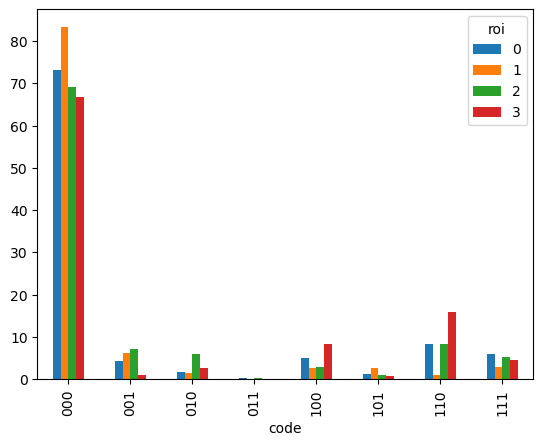

In [15]:
relative.T.plot(kind='bar');